<a href="https://colab.research.google.com/github/neild0/StyleDrop-PyTorch-Interactive/blob/main/styledrop_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!git clone https://github.com/neild0/StyleDrop-PyTorch-Interactive
!mv StyleDrop-PyTorch-Interactive StyleDrop-PyTorch

!pip install omegaconf gdown accelerate==0.12.0 absl-py ml_collections einops wandb ftfy==6.1.1 transformers==4.23.1 loguru webdataset==0.2.5 gradio xformers

Cloning into 'StyleDrop-PyTorch-Interactive'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 373 (delta 43), reused 37 (delta 14), pack-reused 289
Receiving objects: 100% (373/373), 44.01 MiB | 20.08 MiB/s, done.
Resolving deltas: 100% (97/97), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.0/144.0 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!git lfs install
!git clone https://huggingface.co/nzl-thu/MUSE
!mv MUSE/assets/* StyleDrop-PyTorch/assets/
!rm -rf MUSE

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into 'MUSE'...
remote: Enumerating objects: 25, done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 25
Unpacking objects: 100% (25/25), 3.01 KiB | 770.00 KiB/s, done.
Filtering content: 100% (12/12), 9.08 GiB | 149.66 MiB/s, done.
Encountered 1 file(s) that may not have been copied correctly on Windows:
	assets/ckpts/cc3m-285000.ckpt/optimizer.pth

See: `git lfs help smudge` for more details.


In [ ]:
!gdown --id '13S_unB87n6KKuuMdyMnyExW0G1kplTbP' --output StyleDrop-PyTorch/assets/vqgan_jax_strongaug.ckpt

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=13S_unB87n6KKuuMdyMnyExW0G1kplTbP
To: /content/StyleDrop-PyTorch/assets/vqgan_jax_strongaug.ckpt
100% 218M/218M [00:02<00:00, 90.4MB/s]


In [ ]:
!python StyleDrop-PyTorch/extract_empty_feature.py

2023-07-08 08:32:42.610 | DEBUG    | open_clip.transformer:__init__:314 - xattn in transformer of CLIP is True
2023-07-08 08:32:57.045 | DEBUG    | open_clip.transformer:__init__:314 - xattn in transformer of CLIP is True
torch.Size([1, 77, 1280])


Saving 3d render.jpg to 3d render.jpg


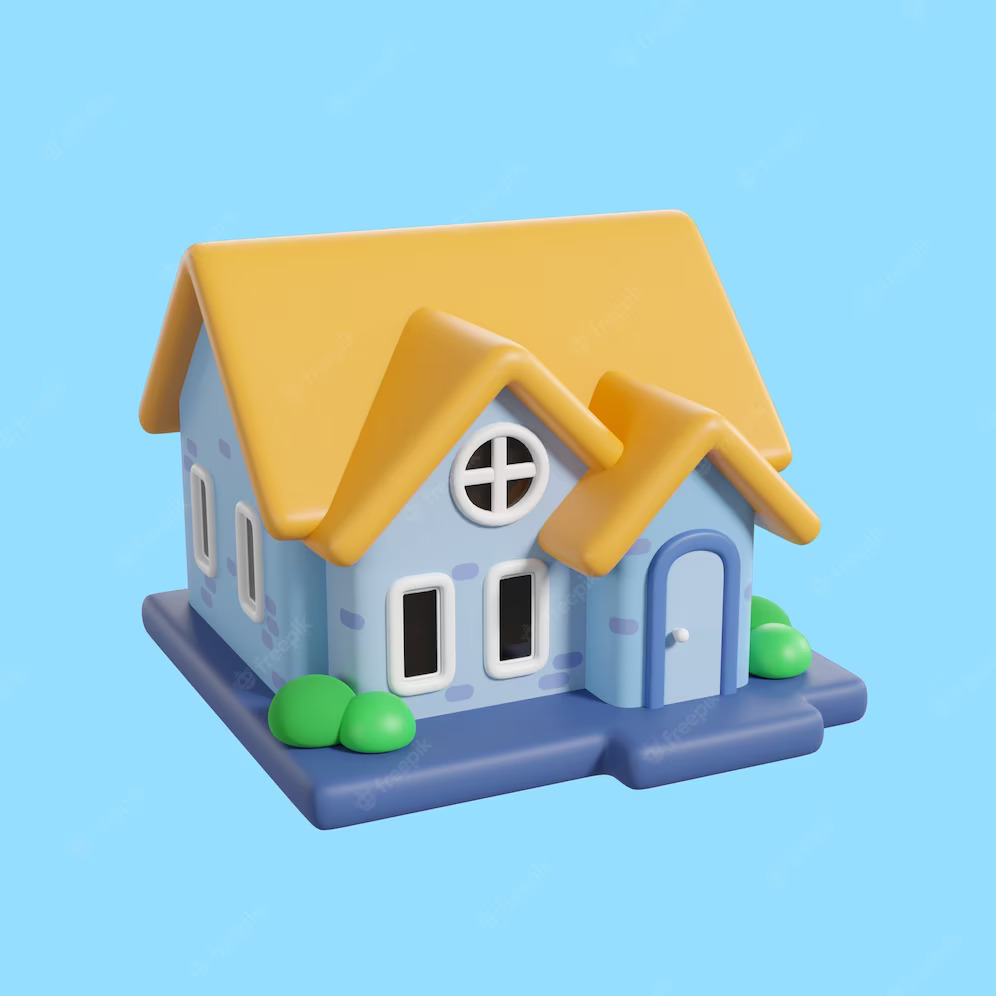

In [22]:
#@title Upload Style File

import shutil
from google.colab import files
import os
from IPython.display import Image, display

# specify the directory you want to move the file to
directory = "/content/StyleDrop-PyTorch/data"

# get all the files in the directory
uploaded = files.upload()

if len(uploaded.keys()) != 1:
    raise Exception("Please only select one file")

for fn in uploaded.keys():

    extension = os.path.splitext(fn)[1]

    if extension == '.jpg':
        # move the file and get the new path
        new_path = shutil.move(fn, f"{directory}/{fn.replace(' ', '_')}")

        # display the image
        display(Image(filename=new_path))

    else:
        raise Exception("Please only select jpg files")


In [ ]:
#@title Describe style image

object_in_image = "a house" #@param {type:"string"}
style_of_image = "3d render" #@param {type:"string"}

# Train model

In [ ]:
import os
import subprocess
import glob

if 'EVAL_CKPT' in os.environ:
    del os.environ['EVAL_CKPT']

if 'ADAPTER' in os.environ:
    del os.environ['ADAPTER']

style_output_folder = style_of_image.replace(" ", "_")

os.environ['OUTPUT_DIR'] = style_output_folder

!cd StyleDrop-PyTorch && accelerate launch --mixed_precision fp16 train_t2i_colab_v2.py --config=configs/custom.py

output_dir ="training_data"
# get a list of all subdirectories
subdirs = glob.glob(f"/content/StyleDrop-PyTorch/{output_dir}/ckpts_II/" + '*/')
subdirs.sort()

last_subdir = subdirs[-1]
adapter = f"{last_subdir}{output_dir}/adapter.pth"

In [ ]:
!cd StyleDrop-PyTorch && python3 gradio_demo.py

2023-07-08 09:15:22.457 | DEBUG    | open_clip.transformer:__init__:314 - xattn in transformer of CLIP is True
2023-07-08 09:15:37.114 | DEBUG    | open_clip.transformer:__init__:314 - xattn in transformer of CLIP is True
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Strict load
Restored from assets/vqgan_jax_strongaug.ckpt
xformers available, will use xformers attention
2023-07-08 09:15:56.554 | DEBUG    | libs.uvit_t2i_vq:__init__:200 - codebook size in nnet: 1024
num vis tokens: 256
2023-07-08 09:16:03.038 | DEBUG    | libs.uvit_t2i_vq:__init__:200 - codebook size in nnet: 1024
num vis tokens: 256
2023-07-08 09:16:09.775 | INFO     | utils:initialize_train_state:178 - nnet has 505693313 parameters
2023-07-08 09:16:10.999 | INFO     | utils:resume:151 - resume from assets/ckpts/cc3m-285000.ckpt
2023-07-08 09:16:10.999 | INFO     | utils:load:119 - load from assets/ckpts/cc3m-285000.ckpt
/content/StyleDrop-PyTorch/gradio_demo.py:197: GradioDeprecationWarning: The `style

In [ ]:
!mv StyleDrop-PyTorch/style_adapter/286000.ckpt/adapter.pth StyleDrop-PyTorch/style_adapter/style.pth